In [791]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import sympy as sp
import numpy as np
import control as ctl
import random

# GERANDO DADOS RUIDOSOS

TransferFunction(array([816.33823141]), array([  1.        ,  16.        , 816.33823141]))

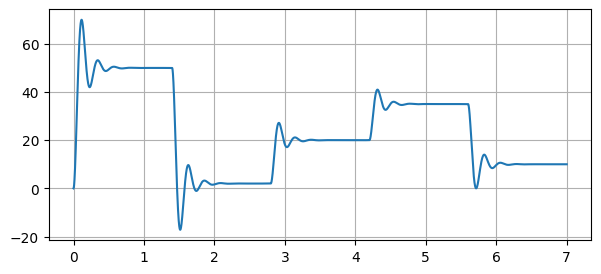

In [792]:
def makeSteps(stepList, length):
    stepSize = length // len(stepList)
    array = []

    for step in stepList:
        array = array + list(step * np.ones(stepSize))

    sizeLeft = len(array) - length

    if sizeLeft > 0:
        array = array + list(stepList[-1] * np.ones(sizeLeft))

    return array

def makeTransferFunction(Ts, UP):
    zeta = -np.log(UP)/np.sqrt(np.pi**2 + np.log(UP)**2)
    Wn = 4/(zeta*Ts)
    s = ctl.TransferFunction.s
    return Wn**2/(s**2 + 2*zeta*Wn*s + Wn**2)

size = 10000
tData = np.linspace(0, 7, size)
uData = makeSteps([50, 2, 20, 35, 10], size)
G = makeTransferFunction(Ts=0.5, UP=0.40)
display(G)

time, response = ctl.forced_response(G, T=tData, U=uData)
plt.figure(figsize=(7, 3))
plt.plot(time, response)
plt.grid()

In [793]:
def noise(value, noiseLevel=0.05):
    if random.randint(0, 100) in [c for c in range(0, 100, 10)]:
        noiseLevel = .9*value

    noise = random.uniform(-noiseLevel, noiseLevel)
    return (value + noise) if (noise < value) else value

df = pd.DataFrame({'time': time, 'input': uData, 'output': response})
df['output'] = df.output.apply(noise)

df.to_csv('DataBase.csv', index=None)
df.head()

,time,input,output
0,0.0000,50.0,-0.038643
1,0.0007,50.0,0.009965
2,0.0014,50.0,0.039706
3,0.0021,50.0,0.079630
4,0.0028,50.0,0.168163


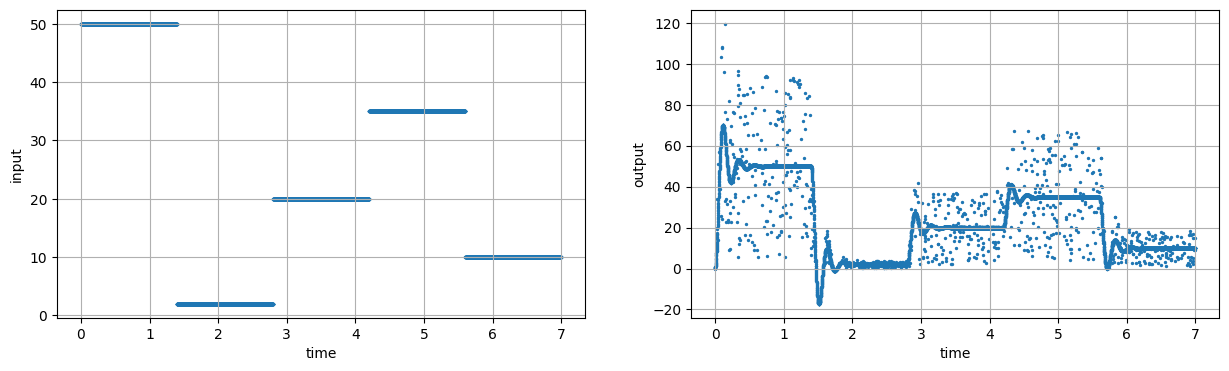

In [794]:
plt.figure(figsize=(15, 4))

plt.subplot(1, 2, 1)
plt.scatter(df.time, df.input, s=2)
plt.xlabel('time'), plt.ylabel('input')
plt.grid()

plt.subplot(1, 2, 2)
plt.scatter(df.time, df.output, s=2)
plt.xlabel('time'), plt.ylabel('output')
plt.grid()

# PADRONIZANDO OS DADOS

In [795]:
def reduceDataFrame(df, size):
    total   = len(df)
    indexes = np.linspace(0, total - 1, size, dtype=int)
    return df.iloc[indexes].reset_index(drop=True)

print('size', len(df), 'reduced to', 5000)
df = reduceDataFrame(df, 5000)

size 10000 reduced to 5000


In [796]:
def normalizeData(df, timeKey, responseKey, T=0.15):
    initTime  = df[timeKey].iloc[0]
    finalTime = df[timeKey].iloc[-1] + T
    timeData = np.arange(initTime, finalTime, T)
    
    lastValue  = df[responseKey].iloc[0]
    desired = []

    for t in timeData:
        filtered = df.loc[df[timeKey] <= t][responseKey]
        
        if not filtered.empty:
            lastValue = filtered.iloc[-1]
        
        desired.append(lastValue)
    
    return timeData, desired


def normalizeTable(df, key, T=0.15):
    table = {key: []}

    for column in df.columns:
        if column == key:
            continue

        xData, yData = normalizeData(df, key, column, T)
        table[column] = yData

    table[key] = xData
    return pd.DataFrame(table) 


T = 0.02
tData, uData = normalizeData(df, 'time', 'input',  T)
tData, yData = normalizeData(df, 'time', 'output', T)

df = normalizeTable(df, 'time', T)
print('size:', len(df))
df.head()

size: 351


,time,input,output
0,0.00,50.0,-0.038643
1,0.02,50.0,6.921122
2,0.04,50.0,23.220744
3,0.06,50.0,42.183636
4,0.08,50.0,59.029023


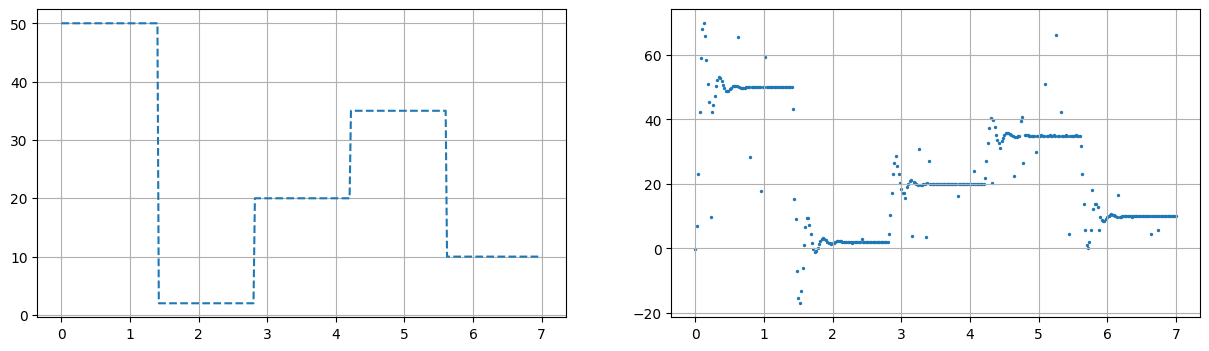

In [797]:
plt.figure(figsize=(15, 4))

plt.subplot(1, 2, 1)
plt.plot(tData, uData, '--')
plt.grid()

plt.subplot(1, 2, 2)
plt.scatter(tData, yData, s=2)
plt.grid()

# FILTRANDO OS DADOS
- **Filtro de Savitzky-Golay**: Este filtro ajusta um polinômio de baixa ordem a uma janela deslizante de pontos de dados, preservando a forma geral dos dados (como picos e vales) enquanto suaviza o ruído. Ideal para preservar as características da curva.

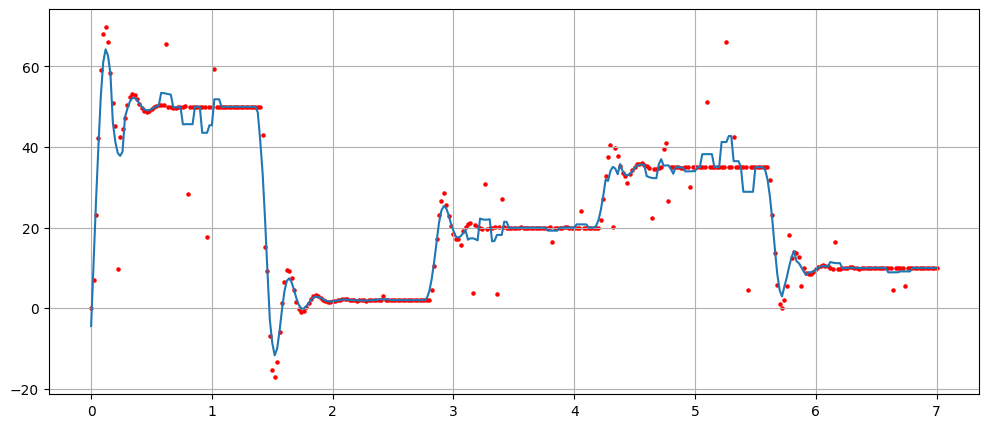

In [798]:
from scipy.signal import savgol_filter
yGolay= savgol_filter(yData, window_length=5, polyorder=1)

plt.figure(figsize=(12, 5))
plt.scatter(tData, yData, s=5, color='red')
plt.plot(tData, yGolay)
plt.grid()

- **Filtro de Média Móvel**: Esse é um filtro simples e eficaz, que substitui cada ponto de dados pela média dos pontos em uma janela móvel.

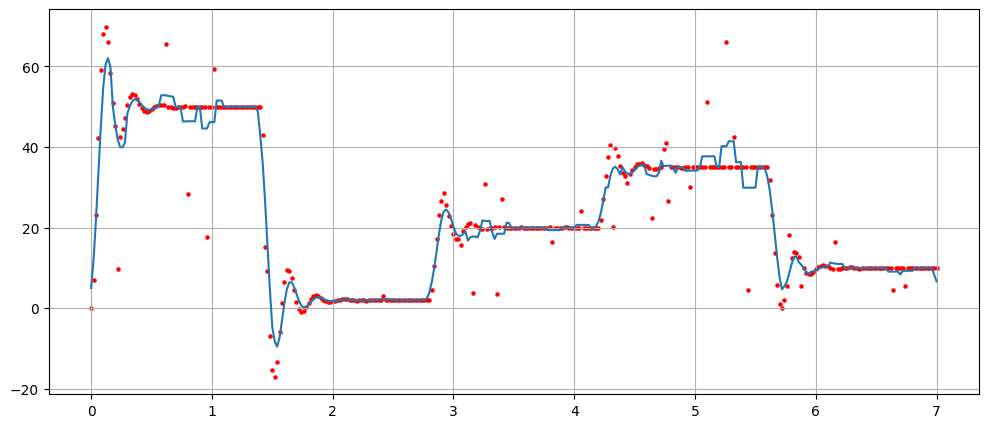

In [799]:
from numpy import convolve
windowSize = 6
yMean = convolve(yData, np.ones(windowSize) / windowSize, mode='same')

plt.figure(figsize=(12, 5))
plt.scatter(tData, yData, s=5, color='red')
plt.plot(tData, yMean)
plt.grid()

- **Filtro Gaussiano**: Esse filtro aplica uma função gaussiana aos dados em uma janela, o que resulta em uma suavização mais natural e contínua.

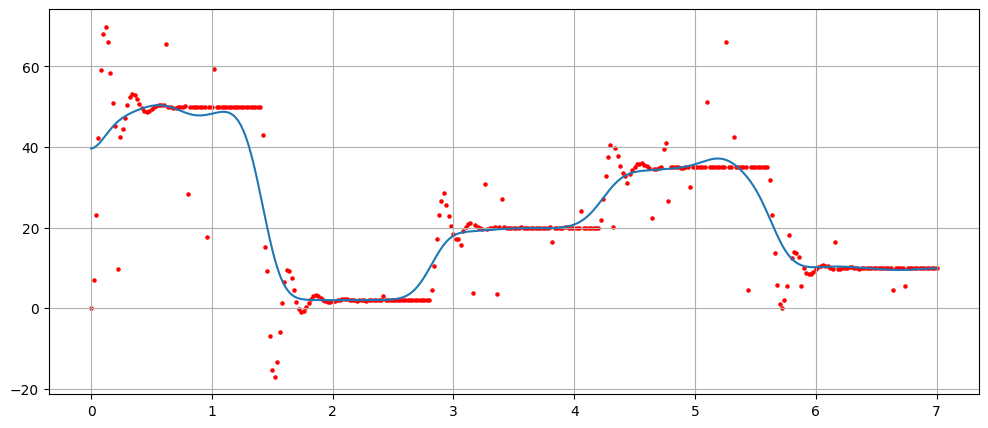

In [800]:

from scipy.ndimage import gaussian_filter
yGaussian = gaussian_filter(yData, sigma=7)

plt.figure(figsize=(12, 5))
plt.scatter(tData, yData, s=5, color='red')
plt.plot(tData, yGaussian)
plt.grid()

- **Filtro de Média Exponencial**: Esse método dá mais peso aos valores mais recentes, o que é útil para séries temporais.

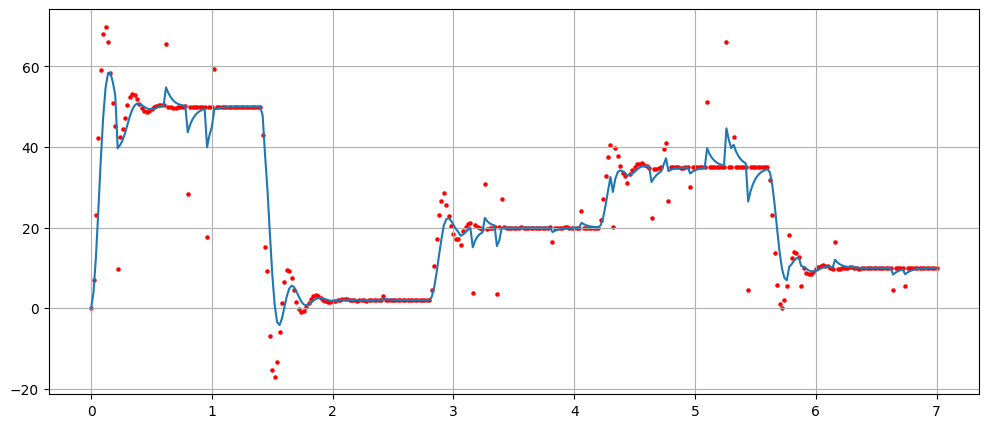

In [801]:
yExpon = pd.Series(yData).ewm(alpha=0.3).mean().to_numpy()

plt.figure(figsize=(12, 5))
plt.scatter(tData, yData, s=5, color='red')
plt.plot(tData, yExpon)
plt.grid()

- **Filtro de Butterworth**: É um filtro passa-baixas que elimina componentes de alta frequência e é muito usado para sinais onde queremos eliminar ruídos de alta frequência.

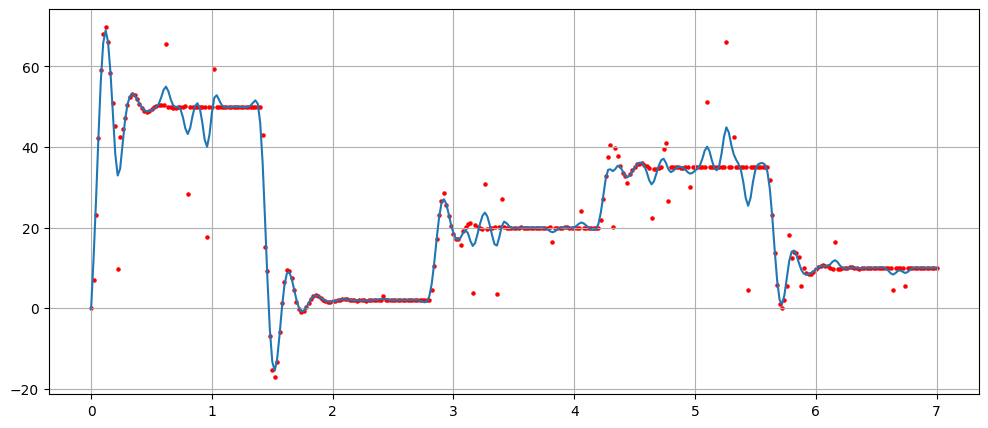

In [802]:
from scipy.signal import butter, filtfilt

order = 2           # Ordem do filtro
cutoff_freq = 0.3  # Frequência de corte (ajuste conforme seu sinal)
b, a = butter(order, cutoff_freq, btype='low', analog=False)
yButterworth = filtfilt(b, a, yData)

plt.figure(figsize=(12, 5))
plt.scatter(tData, yData, s=5, color='red')
plt.plot(tData, yButterworth)
plt.grid()

**Escolhendo o Filtro de Melhor Desempenho**

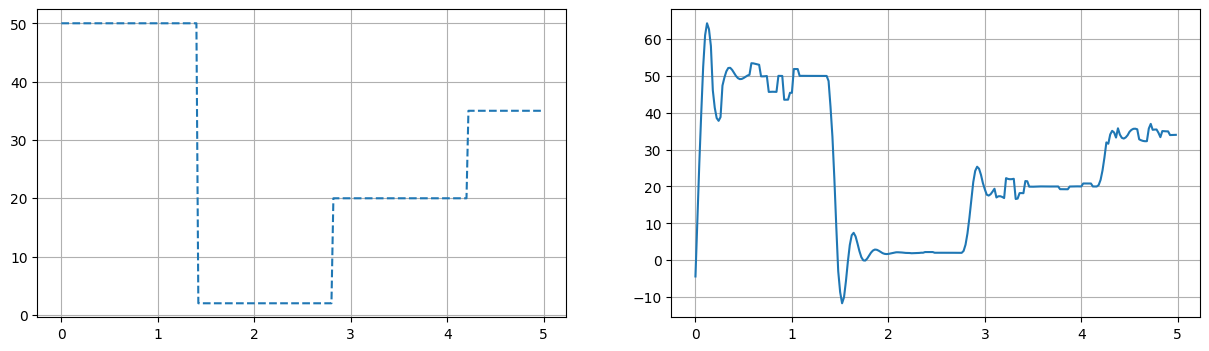

In [803]:
df['output'] = yGolay
df = df.loc[df.time < 5]

plt.figure(figsize=(15, 4))

plt.subplot(1, 2, 1)
plt.plot(df.time, df.input, '--')
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(df.time, df.output)
plt.grid()

# DATA FITTING
O gráfico expressa a função de transferência no domínio do tempo $Y(s) = L^{-1}\{y(t)\}$, podemos encontrar $y(t)$ usando data fitting, encontrando uma função própria que se encaixe nos dados

In [804]:
tData, uData, yData = df.time.values, df.input.values, df.output.values

In [805]:
def g(u, a, b, c):
    s = ctl.TransferFunction.s
    G = a/(s**2 + b*s + c)
    return ctl.forced_response(G, T=tData, U=uData)[1]

def getFunction(xDados, yDados):
    coeficientes = curve_fit(g, xDados, yDados, maxfev=1000000000)  # MÁXIMO DE ITERAÇÕES
    return list(coeficientes[0])

In [806]:
coefs = getFunction(uData, yData)  
coefs

[872.041085208258, 19.344808986634067, 896.5139900548635]

In [807]:
s = ctl.TransferFunction.s
a, b, c = coefs

G = a/(s**2 + b*s + c)
G

TransferFunction(array([872.04108521]), array([  1.        ,  19.34480899, 896.51399005]))

### CONFERINDO COM A DATABASE

In [811]:
df = pd.read_csv('DataBase.csv')
tData, uData, yData = df.time.values, df.input.values, df.output.values

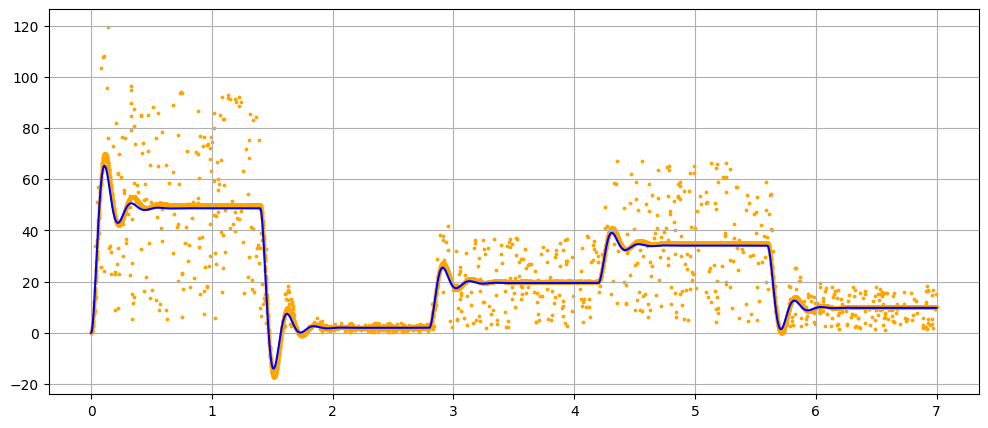

In [813]:
time, response = ctl.forced_response(G, T=tData, U=uData)

plt.figure(figsize=(12, 5))
plt.plot(time, response, color='blue')
plt.scatter(time, yData, color='orange', s=3)
plt.grid()

In [809]:
def sympyFunction(tf):
    num, den = ctl.tfdata(tf)
    s = sp.var('s')
    num_expr = sum(coef*s**i for i, coef in enumerate(num[0][0][::-1]))
    den_expr = sum(coef*s**i for i, coef in enumerate(den[0][0][::-1]))
    sympy_system = num_expr/den_expr
    return sympy_system

def roundSympyFunction(expr, num_digits=4):
    return expr.xreplace({n: round(n, num_digits) for n in expr.atoms(sp.Float)})

print(sympyFunction(G))

872.041085208258/(1.0*s**2 + 19.3448089866341*s + 896.513990054863)
